<a href="https://colab.research.google.com/github/sua11111/AI_06_project_sua/blob/main/VEA_face_1_1_model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip -uq /content/drive/Shareddrives/스타일봇_3조/convert_add2.zip -d /content/face2

In [ ]:
!unzip -uq /content/imgs_change.zip -d /content/face

In [ ]:
from IPython import display

from skimage import io
from skimage.transform import resize
import numpy as np
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, Conv2DTranspose
from keras.models import Sequential, Model
import time
import math

SIZE_H=512
SIZE_W=512

In [ ]:
def load_imgs(images_path):
  a=[]
  image=np.empty((0,SIZE_H,SIZE_W,3),np.float32)
  images_path.sort()
  for path in images_path:
    a=io.imread(path)
    a=resize(a,(SIZE_H,SIZE_W))
    image=np.append(image,np.array([a[:,:,:3]]),axis=0)

  image_enc=tf.convert_to_tensor(image,tf.float32)
  
  return image_enc

In [ ]:
def create_encoder():
  ei=tf.keras.layers.Input((SIZE_H, SIZE_H, 3))
  d1_1=tf.keras.layers.Conv2D(filters=32, kernel_size=4, strides=(2, 2), activation='relu',padding='same')(ei)
  d1_2=tf.keras.layers.Conv2D(filters=32, kernel_size=8, strides=(2, 2), activation='relu',padding='same')(ei)
  d1=Concatenate()([d1_1,d1_2])

  d2_1=tf.keras.layers.Conv2D(filters=64, kernel_size=4, strides=(2, 2), activation='relu',padding='same')(d1)
  d2_2=tf.keras.layers.Conv2D(filters=64, kernel_size=8, strides=(2, 2), activation='relu',padding='same')(d1)
  d2=Concatenate()([d2_1,d2_2])

  d3_1=tf.keras.layers.Conv2D(filters=128, kernel_size=4, strides=(2, 2), activation='relu',padding='same')(d2)
  d3_2=tf.keras.layers.Conv2D(filters=128, kernel_size=8, strides=(2, 2), activation='relu',padding='same')(d2)
  d3=Concatenate()([d3_1,d3_2])

  sd1=tf.keras.layers.Conv2D(filters=32, kernel_size=16, strides=(8, 8), activation='relu',padding='same')(ei)

  d4=Concatenate()([d3,sd1])
  d5=tf.keras.layers.Flatten()(d4)
  d6=tf.keras.layers.Dense(latent_dim + latent_dim)(d5)
  
  return Model(ei,d6)

In [ ]:
def create_decoder():
  di=tf.keras.layers.Input((latent_dim))
  u1 = tf.keras.layers.InputLayer(input_shape=(latent_dim,))(di)
  u2 = tf.keras.layers.Dense(units=(SIZE_H//2**3)*(SIZE_H//2**3)*64, activation=tf.nn.relu)(u1)
  u3 = tf.keras.layers.Reshape(target_shape=((SIZE_H//2**3), (SIZE_H//2**3), 64))(u2)

  su1=tf.keras.layers.Conv2DTranspose(filters=6, kernel_size=16, strides=8, padding='same',activation='relu')(u3)

  u4 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=4, strides=2, padding='same',activation='relu')(u3)
  u4_2 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=8, strides=4, padding='same',activation='relu')(u3)

  u5 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=4, strides=2, padding='same',activation='relu')(u4)
  u5 = Concatenate()([u5,u4_2])

  u6 = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=4, strides=2, padding='same',activation='relu')(u5)
  u7 = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=4, strides=1, padding='same')(u6)

  u8 = Concatenate()([u7,su1])
  u9 = tf.keras.layers.Dense(16)(u8)
  u10 = tf.keras.layers.Dense(3)(u9)

  return Model(di,u10)

In [ ]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = create_encoder()

    self.decoder = create_decoder()

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [ ]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  print("train_step activate")
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-4)

# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 100

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.

model = CVAE(latent_dim)

In [ ]:
import os

def generate_and_save_images(model, epoch, batch, test_sample,latent_dim,stored=False):
  
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  if stored:
    stored_z.append(z)
  predictions = model.sample(z)

  fig = plt.figure(figsize=(30, 13))
  for i in range(min(28,predictions.shape[0])):
    plt.subplot(4, 7, i + 1)
    plt.imshow(predictions[i])
    plt.title(f"pred {i}",fontsize=10)
    plt.axis('off')
    
  if os.path.isdir(f"pred_images_dim_{latent_dim}") == False:
    os.mkdir(f"pred_images_dim_{latent_dim}")
  plt.savefig(os.path.join(f"pred_images_dim_{latent_dim}",'image_at_epoch_{:04d}_{:04d}.png'.format(epoch,batch)))
  plt.show()

Epoch: 100/100, batch: 360/370, time: 54.4, ELBO loss: -120343.5


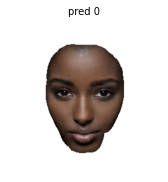

Epoch: 100/100, batch: 361/370, time: 54.9067, ELBO loss: -157142.578125
Epoch: 100/100, batch: 362/370, time: 55.0453, ELBO loss: -145055.75
Epoch: 100/100, batch: 363/370, time: 55.1821, ELBO loss: -103982.3984375
Epoch: 100/100, batch: 364/370, time: 55.3303, ELBO loss: -139463.765625
Epoch: 100/100, batch: 365/370, time: 55.4599, ELBO loss: -116795.203125
Epoch: 100/100, batch: 366/370, time: 55.5958, ELBO loss: -140006.1875
Epoch: 100/100, batch: 367/370, time: 55.7333, ELBO loss: -134068.328125
Epoch: 100/100, batch: 368/370, time: 55.8706, ELBO loss: -127566.90625
Epoch: 100/100, batch: 369/370, time: 56.0175, ELBO loss: -124800.09375
Epoch: 100/100, batch: 370/370, time: 56.1554, ELBO loss: -141981.171875


In [ ]:
import random

epochs=100
batch_size=1
save_point=30

path=glob.glob('/content/face/*.png')+glob.glob('/content/face2/B/*.png')
patch=(round(SIZE_H/2**4),round(SIZE_W/2**4),1)


for epoch in range(1, epochs + 1):
  start_time = time.time()
  random.shuffle(path)
  for num in range(1,math.ceil(len(path)/batch_size)+1):
    image_enc=load_imgs(path[batch_size*(num-1):batch_size*(num)])

    train_step(model, image_enc, optimizer)
    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    loss(compute_loss(model, image_enc))
    elbo = -loss.result()
    
    print(f"Epoch: {epoch}/{epochs}, batch: {num}/{math.ceil(len(path)/batch_size)}, time: {round(end_time - start_time,4)}, ELBO loss: {elbo}")

    if math.ceil(len(path)/batch_size)+1<save_point:
      if epoch%save_point==0:
        display.clear_output()
        print(f"Epoch: {epoch}/{epochs}, batch: {num}/{math.ceil(len(path)/batch_size)}, time: {round(end_time - start_time,4)}, ELBO loss: {elbo}")
        generate_and_save_images(model, epoch, num, image_enc,latent_dim)
    else:
      if num%save_point==0:
        display.clear_output()
        print(f"Epoch: {epoch}/{epochs}, batch: {num}/{math.ceil(len(path)/batch_size)}, time: {round(end_time - start_time,4)}, ELBO loss: {elbo}")
        generate_and_save_images(model, epoch, num, image_enc,latent_dim)

In [ ]:
#모델 가중치 정보 저장
model.encoder.save_weights('/content/model_2_encoder_weight/model_encoder')
model.decoder.save_weights('/content/model_2_decoder_weight/model_decoder')

In [ ]:
#모델 가중치 정보 압축 저장
!zip -r /content/drive/MyDrive/model_2_encoder_weight.zip /content/model_2_encoder_weight
!zip -r /content/drive/MyDrive/model_2_decoder_weight.zip /content/model_2_decoder_weight

  adding: content/model_2_encoder_weight/ (stored 0%)
  adding: content/model_2_encoder_weight/model_encoder.index (deflated 59%)
  adding: content/model_2_encoder_weight/checkpoint (deflated 43%)
  adding: content/model_2_encoder_weight/model_encoder.data-00000-of-00001 (deflated 6%)
  adding: content/model_2_decoder_weight/ (stored 0%)
  adding: content/model_2_decoder_weight/checkpoint (deflated 43%)
  adding: content/model_2_decoder_weight/model_decoder.data-00000-of-00001 (deflated 7%)
  adding: content/model_2_decoder_weight/model_decoder.index (deflated 60%)


In [ ]:
#저장한 가중치 로드
model=CVAE(latent_dim)
model.encoder.load_weights('/content/model_2_encoder_weight/model_encoder')
model.decoder.load_weights('/content/model_2_decoder_weight/model_decoder')

In [ ]:
#이미지들의 latent_dim 정보를 저장
stored_z=[]
for img_path in path:
  image_enc=load_imgs([img_path])
  mean, logvar = model.encode(image_enc)
  z = model.reparameterize(mean, logvar)
  stored_z.append(z)

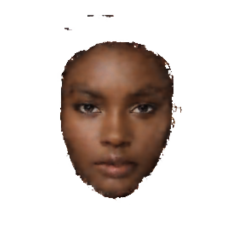

In [ ]:
def generate(model, epoch, z,latent_dim):
  predictions = model.sample(z)
  io.imsave(f'mean_img.png',np.array(predictions[0]))
  plt.imshow(predictions[0])
  plt.axis('off')
  plt.show()

#pred 1과 pred 13 임베딩 백터 값의 중간값을 이용 예측 진행
aa=tf.convert_to_tensor([stored_z[210][0]+stored_z[150][0]],tf.float32)

generate(model,0,aa/2,latent_dim)

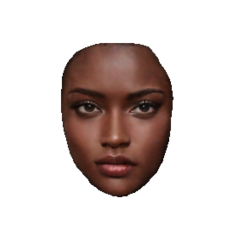

In [ ]:
aa=tf.convert_to_tensor([stored_z[1][0]],tf.float32)
generate(model,0,aa,latent_dim)

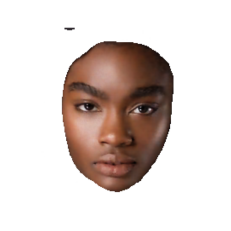

In [ ]:
aa=tf.convert_to_tensor([stored_z[150][0]],tf.float32)
generate(model,0,aa,latent_dim)

In [ ]:
import pandas as pd

a=[]
for row in stored_z:
  a.append(np.array(row[0]))

df=pd.DataFrame(np.array(a))
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,-0.505620,0.501476,-0.828136,1.653434,1.514021,-0.217621,-1.327021,0.941034,0.530970,-0.527977,0.025182,-0.643689,-0.735387,0.623022,0.222479,-0.218705,0.347310,-1.260789,2.091978,0.194457,-0.495907,-0.140250,-0.622890,-0.911902,-0.082806,-1.000260,0.523771,0.538469,-0.052369,-0.224330,1.510234,0.204218,1.620556,0.151113,1.220247,-0.824784,-0.084516,1.687676,-0.408885,-0.439892,...,-0.917869,2.757404,0.118150,-0.943822,-0.431497,-1.020152,0.527391,-0.225016,0.279402,0.292086,0.828359,1.346386,0.332772,0.429740,-1.716018,-0.481354,-2.898940,-0.854237,-1.828670,0.305752,-2.025646,-0.262168,-0.651456,0.392877,0.406078,-1.092429,-1.442863,1.500471,-0.302958,0.151948,1.111961,1.088085,-0.412541,-0.725484,-0.655961,0.957381,0.854022,0.625397,0.895205,-0.820850
1,-1.409120,-0.231162,0.191619,0.350716,-0.132087,0.426030,-0.526330,0.358993,2.378111,-0.660079,0.962065,1.203447,-0.219499,-0.160066,0.503445,0.489663,0.956957,-0.034265,-0.958983,-0.344726,0.023014,0.276551,-0.921777,-0.173314,0.554677,0.957984,1.232173,1.426325,-0.570529,0.344243,-0.768461,-0.743194,-0.475720,-0.263103,-1.165997,0.604161,-0.023516,-0.810609,-0.509263,-0.972202,...,-1.222815,0.961542,0.400371,-0.051344,-0.410957,0.741384,-1.124081,1.182617,1.545062,-0.471082,-0.284286,1.419687,0.703037,1.128657,0.868466,0.241306,-0.183079,-0.398328,-1.307778,0.536631,0.653589,-0.568409,0.127049,-0.286049,-0.959982,0.740835,-2.543070,-0.108907,-0.825286,0.788997,-0.703892,-0.687988,-0.762183,1.197163,-0.185930,0.043680,-0.476803,1.366197,-0.219109,-0.944768
2,0.095318,-0.426659,-0.702296,1.014723,0.081915,0.561357,-0.648182,-0.485086,0.978882,-0.702443,-0.470217,-0.526284,-1.037695,-1.030468,0.777820,-0.527126,-0.864410,0.358456,0.910265,0.300551,0.098179,1.354798,1.135731,0.336610,0.216519,0.010235,0.578931,1.730207,-0.857744,-2.183668,-1.010499,-0.260945,-0.195265,-0.344207,0.034009,0.013766,1.093531,-1.199762,0.384030,-0.827868,...,-0.684035,-0.682082,1.131851,1.407955,1.210061,0.512733,-0.302503,-1.066088,-0.273921,0.554091,-0.332091,-0.542163,-1.726873,0.482577,0.601674,0.311034,0.558527,0.802403,-0.155739,-1.756652,-0.019381,0.225186,0.100612,0.323305,-0.954365,0.924853,-0.646902,-0.556879,-0.120769,-2.058421,-0.331942,-0.170506,-1.302688,-0.291826,-0.308672,-1.248248,1.122646,-1.741200,-0.333531,-0.410943
3,-0.218564,0.684699,-1.667929,0.805539,0.360031,-0.505029,-0.221958,0.015776,1.899236,-0.178941,0.577469,0.278803,0.712347,-0.487359,0.398716,0.300538,0.792617,0.879809,-1.068884,-0.194779,-0.835511,0.497192,0.788126,0.423688,-0.556174,0.865536,-0.596483,0.977839,0.126194,-0.470426,-0.803293,1.536909,0.627010,-0.392493,0.696791,0.688712,0.737899,-0.936101,-0.235028,-1.484851,...,-0.341478,0.306892,-1.339476,-1.192218,1.266047,-0.551558,0.206283,0.140866,0.023621,-0.207369,1.201303,-0.737757,0.844864,-0.834976,-0.678166,0.967888,-1.121903,1.250714,-2.010876,-0.428794,-0.966000,-0.353450,-0.795674,-1.316387,0.421735,0.880888,-0.972193,-0.586231,-1.172575,0.836068,-1.316844,1.152039,-0.402955,0.758736,-1.935995,-0.146008,-1.525683,-1.167810,-0.537523,-0.156153
4,-0.010903,-0.067542,0.042823,1.283004,0.324018,-1.474295,-0.228320,-1.423365,-0.152354,-0.829009,-0.750541,-1.308808,0.608970,-0.802252,0.678707,0.001097,-1.028411,0.953742,0.078122,-0.128787,-0.890681,1.609441,-0.128484,0.095677,1.515763,-0.921982,-0.961858,1.633210,-0.710625,-1.178395,0.082357,0.520055,-0.646545,1.571399,-0.153819,1.296507,0.873143,1.319167,-0.797470,0.566317,...,-1.822189,-1.825948,-0.135815,-1.085004,2.177818,-0.852909,0.810697,-0.035688,0.172905,-0.776185,-0.677428,-0.391767,-0.198912,-0.563768,0.273495,0.742557,-1.041705,-0.695566,-0.323394,-0.245986,-2.553886,-1.334142,1.835738,-0.235354,-0.146283,-0.738477,-1.713703,-0.314006,0.008640,-2.338343,0.186386,

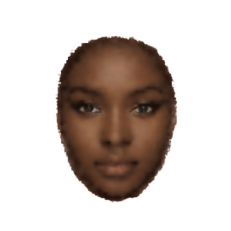

In [ ]:
seting=tf.convert_to_tensor([df.mean().array*1],tf.float32)

generate(model,0,seting,latent_dim)

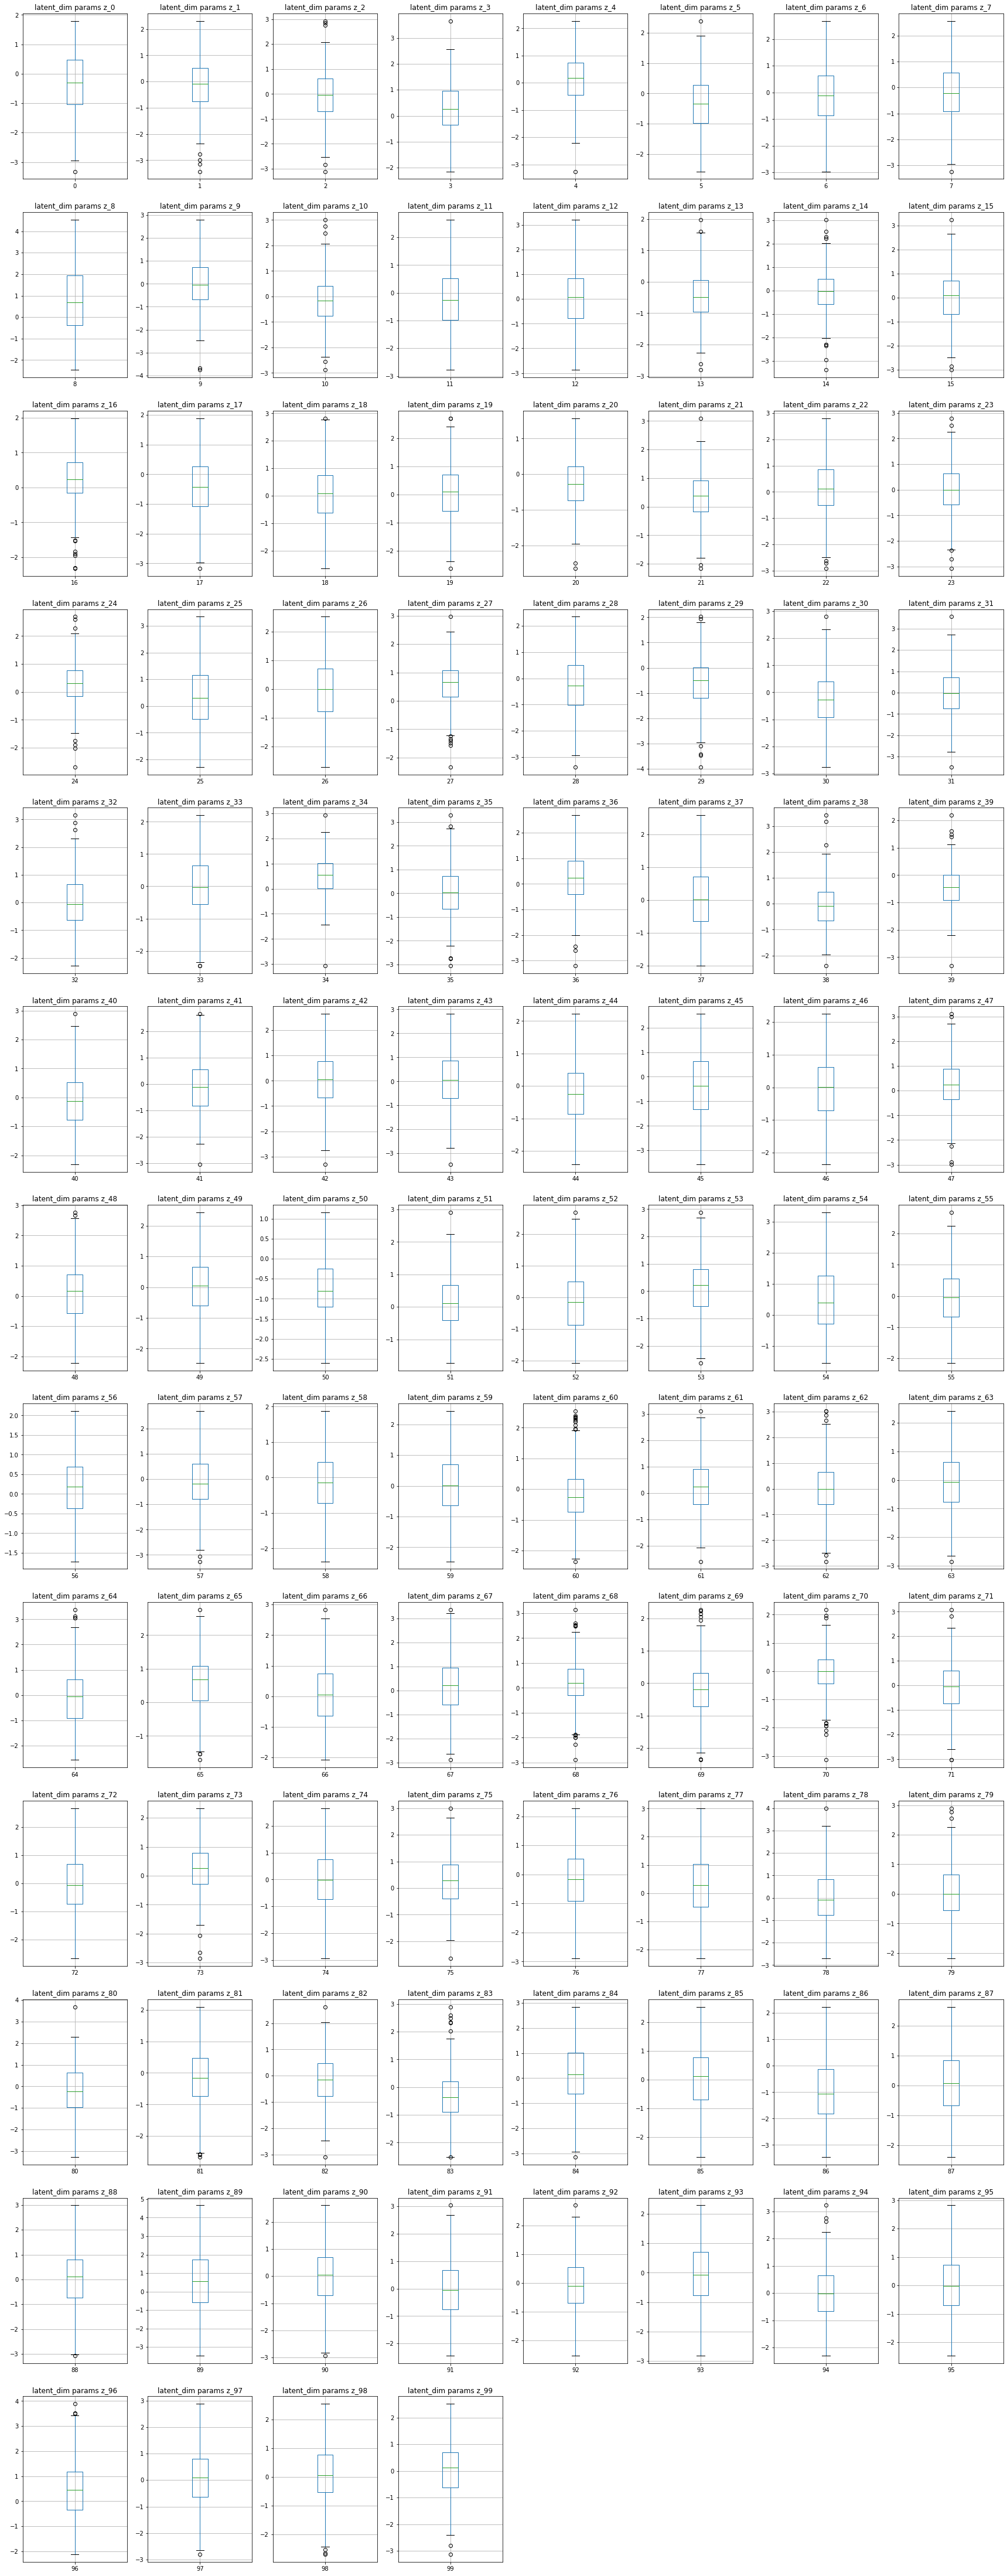

In [ ]:
#각 임베딩 백터의 값의 변화를 시각화
fig = plt.figure(figsize=(30, 80))
for i in df:
  plt.subplot(13, 8, i + 1)
  plt.title(f'latent_dim params z_{i}')
  df[[i]].boxplot()
  #plt.plot(df[i].tolist())
  #plt.scatter(df.index,df[i].tolist())
  #plt.scatter(13,df[i][13])
plt.show()

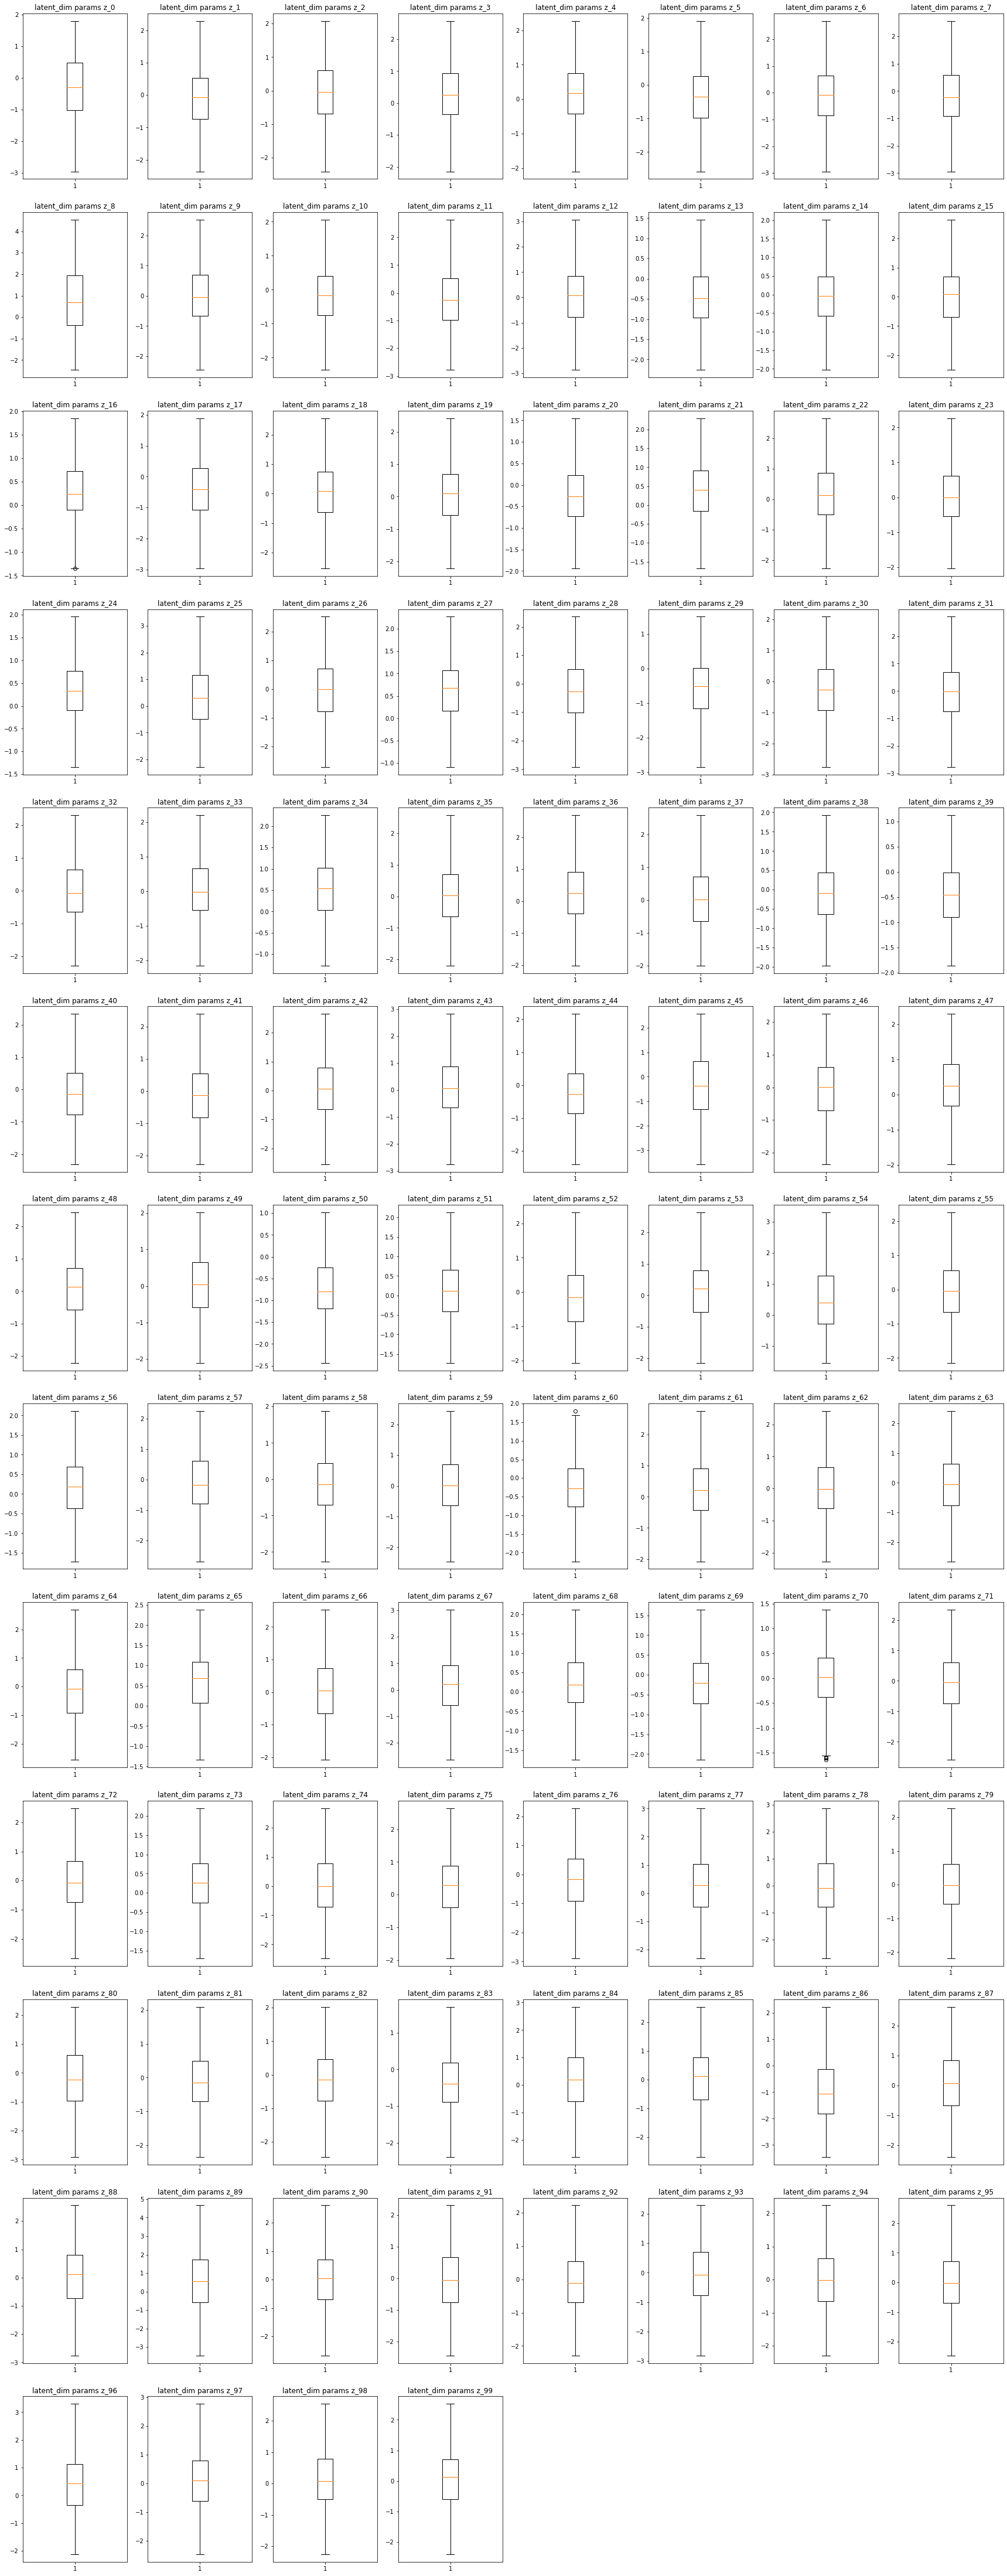

In [ ]:
#각 임베딩 백터의 값의 아웃라이어의 제거 후 평균
setting=[]
fig = plt.figure(figsize=(30, 80))
for i in df:
  q1,q3=np.percentile(df[i],[25,75])
  iqr=q3-q1
  lower_bound=q1-(iqr*1.4)
  upper_bound=q3+(iqr*1.4)
  result=df[i][(df[i]>=lower_bound) & (df[i]<=upper_bound)]
  setting.append(result.mean())
  plt.subplot(13, 8, i + 1)
  plt.title(f'latent_dim params z_{i}')
  plt.boxplot(result)
plt.show()

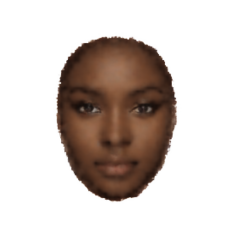

In [ ]:
seting=tf.convert_to_tensor([setting],tf.float32)
generate(model,0,seting,latent_dim)